In [1]:
#import pip

In [2]:
# pip.main(["install", "openpyxl"])
#pip.main(["install","scikit-learn.linear_model"])

In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, auc

In [4]:
#path = Path.cwd().joinpath("Raw_sensing_data","CO","Cu-COF-DC-8","N2_dry").rglob("*.xlsx")

#for i in path:
#    print(i)

In [64]:
def read_data(cof, gas, carrier, ppm):

    # get path to appropriate file
    path = Path.cwd().joinpath("Raw_sensing_data",gas,cof,carrier,).rglob("*.xlsx")
    #print(path)
    # some folders contain multiple excel files, so append all to a list
    files = []
    for file in path:
        files.append(file)
    #print(files)
    # extract data from Excel files in list
    dfs = []
    for p in files:
        df = pd.read_excel(p,header=6,names=['time','GB1 DeltaG/G0','GB2 DeltaG/G0','GB3 DeltaG/G0','GB4 DeltaG/G0'],usecols="B,D,H,L,P")
        # exposure time begins at 750s
        # exposure time ends 2580s later (3330s)
        df_chopped = df.iloc[1499:6660]
        
        
        dfs.append(df_chopped)
                
    return dfs
# returns pandas data frame with this data. two columns: time, DeltaG/G0

In [65]:
#print(read_data("Cu-COF-DC-8","CO","N2_dry",80))
data = read_data("Cu-COF-DC-8","H2S","air_humid",80)

In [66]:
#print(data)

In [67]:
# partition data into K sec windows in the first N sec 
# after substance introduction (750 sec)

K = 40
N = 400
n_partitions = int(N/K)

dfs = []
for i in range(n_partitions):
    dfs.append(data[0].iloc[i*K:(i+1)*K])

#print(dfs)
#print(dfs[1]['time'])

X = dfs[3].loc[:,"time"].to_numpy().reshape(-1,1)
Y = dfs[3].loc[:,"GB3 DeltaG/G0"].to_numpy().reshape(-1,1)
reg = LinearRegression().fit(X,Y)

Regression coefficients:  [[0.93672504]]
Mean squared error  0.095172265486779


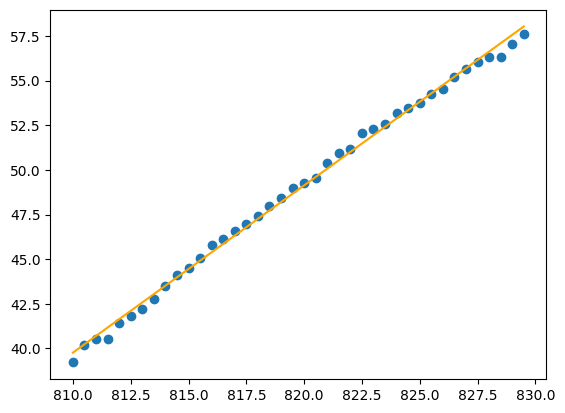

In [68]:
y_fit = reg.predict(X)


print("Regression coefficients: ",reg.coef_)
print("Mean squared error ", mean_squared_error(Y,y_fit))



plt.scatter(X,Y)
plt.plot(X,y_fit,color="orange")

plt.show()


In [69]:
# worse way to get initial slope
"""
print(data[0].loc[1497:4000])
axes = data[0].plot(x='time',y='DeltaG/G0',xlim=(749.5,900),ylim=(-100,100))


init_t = 1497
init_t_end = 1570
per = 10
slopes = data[0].diff(periods = per).loc[init_t:init_t_end,"DeltaG/G0"] / data[0].diff(periods = per).loc[init_t:init_t_end,"time"]
#slopes = data[0].diff().loc[1400:1600,"DeltaG/G0"] / 0.5

print(slopes)
maxslope = slopes.max()
maxloc = slopes.idxmax()
print(maxslope,maxloc)
print(data[0].loc[init_t,"time"],data[0].loc[init_t_end,"time"])

x = [data[0].loc[maxloc-per,"time"],data[0].loc[maxloc+40-per,"time"]]
y = [data[0].loc[maxloc-per,"DeltaG/G0"],(x[1]-x[0])*maxslope + data[0].loc[maxloc-per,"DeltaG/G0"]]

axes.plot(x,y,'orange')

axes2 = data[0].plot(x='time',y='DeltaG/G0',xlim=(749.5,829.5),ylim=(-25,25))
axes2.plot(x,y,'orange') """

'\nprint(data[0].loc[1497:4000])\naxes = data[0].plot(x=\'time\',y=\'DeltaG/G0\',xlim=(749.5,900),ylim=(-100,100))\n\n\ninit_t = 1497\ninit_t_end = 1570\nper = 10\nslopes = data[0].diff(periods = per).loc[init_t:init_t_end,"DeltaG/G0"] / data[0].diff(periods = per).loc[init_t:init_t_end,"time"]\n#slopes = data[0].diff().loc[1400:1600,"DeltaG/G0"] / 0.5\n\nprint(slopes)\nmaxslope = slopes.max()\nmaxloc = slopes.idxmax()\nprint(maxslope,maxloc)\nprint(data[0].loc[init_t,"time"],data[0].loc[init_t_end,"time"])\n\nx = [data[0].loc[maxloc-per,"time"],data[0].loc[maxloc+40-per,"time"]]\ny = [data[0].loc[maxloc-per,"DeltaG/G0"],(x[1]-x[0])*maxslope + data[0].loc[maxloc-per,"DeltaG/G0"]]\n\naxes.plot(x,y,\'orange\')\n\naxes2 = data[0].plot(x=\'time\',y=\'DeltaG/G0\',xlim=(749.5,829.5),ylim=(-25,25))\naxes2.plot(x,y,\'orange\') '

In [70]:
# function to do linear regression on a single partition of data
    # input: partition of time & each DeltaG/G0, j := which DeltaG/G0 column (1,2,3, or 4) 
    # output: linear regression coefficients and mean squared errors
def lin_reg(df,j):
    X = df.loc[:,"time"].to_numpy().reshape(-1,1)
    Y = df.loc[:,'GB'+str(j)+" DeltaG/G0"].to_numpy().reshape(-1,1)
    reg = LinearRegression().fit(X,Y)
    y_fit = reg.predict(X)
    mse = mean_squared_error(Y,y_fit)

    coef = reg.coef_.tolist().pop().pop()

    #print("coef from lin_reg function: ",coef)

    return [coef,mse,X,Y,y_fit]

In [71]:
class SensorResponse:
    def __init__(self, cof, gas, carrier_gas, ppm):
        self.cof = cof
        self.gas = gas
        self.carrier_gas = carrier_gas
        self.ppm = ppm

        self.data = read_data(cof,gas,carrier_gas,ppm)
        
    # read in the data, do processing to get the features.
    # store data here too for viz 

    # Define function to estimate initial slope of data
    # partition_size := size of the time window for partitions (ex: 30sec)
    # total_time_window := the total time after introduction of substance
    # considered to compute intial slope (ex: 1000s)
    # k := which element of the self.data, default k=0
    # mse_bound := bound on acceptable mean squared error for initial slope linear regression
    def compute_initial_slope(self, partition_size=100, total_time_window=600,k=0,mse_bound=1):
        initial_slopes = []
        n_partitions = int(total_time_window/partition_size)
        partitions = []
        #partition the data
        for i in range(n_partitions):
            partitions.append(self.data[k].iloc[i*partition_size:(i+1)*partition_size])
        
        # data for plots
        Yregs = [] #regression data
        Ys = [] #data from initial slope partition
        Xs = []
        # perform linear regression on partitions and append (coefficient, MSE) pairs
        # to slopes_mse
        for j in range(1,5):
            slopes_mse = []
            for df in partitions:
                regdata = lin_reg(df,j)
                
                # condition on mean squared error: only include data if MSE is small enough
                if regdata[1] < mse_bound:
                    slopes_mse.append(regdata)

                
            if bool(slopes_mse) == 0:
                print("GB"+str(j)+"DeltaG/G0 has no initial slopes that satisfy mse bound. ")        
            # take initial slope to be the max of the linear regression slopes which satisfy the MSE condition
            #print(slopes_mse)
            slope_msedf = pd.DataFrame(slopes_mse)
            #print("slope_msedf: ", slope_msedf)
            initial_slopeloc = slope_msedf[0].abs().idxmax()
            #print("initial_slopeloc: ",initial_slopeloc)
            initial_slope = slope_msedf[0].abs().max()
            initial_slopes.append(initial_slope)

            #plot entire time series of exposure
            #axes = self.data[k].plot(x='time',y='GB'+str(j)+' DeltaG/G0') 
            #plot initial slope on top of entire time series data
            #axes.plot(slope_msedf[2].iloc[initial_slopeloc],slope_msedf[4].iloc[initial_slopeloc],color="orange")      
            #store data for visualization/plots
            Xs.append(slope_msedf[2].iloc[initial_slopeloc])
            Yregs.append(slope_msedf[4].iloc[initial_slopeloc])
            Ys.append(slope_msedf[3].iloc[initial_slopeloc])
             
            #plot just the linear regression on top of partition data
            #fig, ax = plt.subplots()
            #scatter = ax.scatter(slope_msedf[2].iloc[initial_slopeloc],slope_msedf[3].iloc[initial_slopeloc])
            
            #ax.plot(slope_msedf[2].iloc[initial_slopeloc],slope_msedf[4].iloc[initial_slopeloc],color="orange")

        return [initial_slopes,Xs,Yregs,Ys]

    def compute_saturation(self,k=0):
        p_length = 300
        n_partitions = int((2*2580)/p_length)
        partitions = []
        #partition the data
        for i in range(n_partitions+1):
            partitions.append(self.data[k].iloc[i*p_length:(i+1)*p_length])
        
        #store average value of GBx DeltaG/G0 for each partition
        #probably a better way to do this, 
        #but I was fumbling so much with dataframes this was the only way I got it to work
        average1 = []
        average2 = []
        average3 = []
        average4 = []
        for part in partitions:
            #print(part)
            part = part.drop(columns=['time'])
            avg = part.mean()
            average1.append(avg[0])
            average2.append(avg[1])
            average3.append(avg[2])
            average4.append(avg[3])
        
        saturation = []
        #find max of absolute value of all averages
        for avg in [average1,average2,average3,average4]:
            if max(avg) > abs(min(avg)):
                saturation.append(max(avg))
            else:
                saturation.append(min(avg))

        return saturation
    
    #compute area under curve for each GBx DeltaG/G0 using sklearn auc
    def compute_area(self,k=0):
        X = self.data[k].loc[:,'time'].to_numpy().reshape(-1,1)
        Y1 = self.data[k].loc[:,'GB1 DeltaG/G0'].to_numpy().reshape(-1,1)
        Y2 = self.data[k].loc[:,'GB2 DeltaG/G0'].to_numpy().reshape(-1,1)
        Y3 = self.data[k].loc[:,'GB3 DeltaG/G0'].to_numpy().reshape(-1,1)
        Y4 = self.data[k].loc[:,'GB4 DeltaG/G0'].to_numpy().reshape(-1,1)

        areas = [auc(X,Y1),auc(X,Y2),auc(X,Y3),auc(X,Y4)]
        return areas
    
    def viz(self, save=False,k=0): # viz the data along with the response features or function u fit to it.
        plotdata = self.compute_initial_slope()
        sat = self.compute_saturation()
        for j in range(0,4):
            #full time series plot with initial slope partition
            axes = self.data[k].plot(x='time',y='GB'+str(j+1)+' DeltaG/G0')
            axes.plot(plotdata[1][j],plotdata[2][j])
            axes.axhline(sat[j],color='green',linestyle='dashed')
            #just initial slope linear regression
            fig, ax = plt.subplots()
            scatter = ax.scatter(plotdata[1][j],plotdata[3][j])
            ax.plot(plotdata[1][j],plotdata[2][j],color="orange")

    def vector_representation(self,docnum=0): # returns the vector characterizing the response.
        response = []
        response.append(self.compute_initial_slope(k=docnum)[0])
        response.append(self.compute_saturation(k=docnum))
        response.append(self.compute_area(k=docnum))
        return response

In [72]:
# Test the SensorResponse class initial_slope function
test = SensorResponse("Cu-COF-DC-8","H2S","air_dry",80)


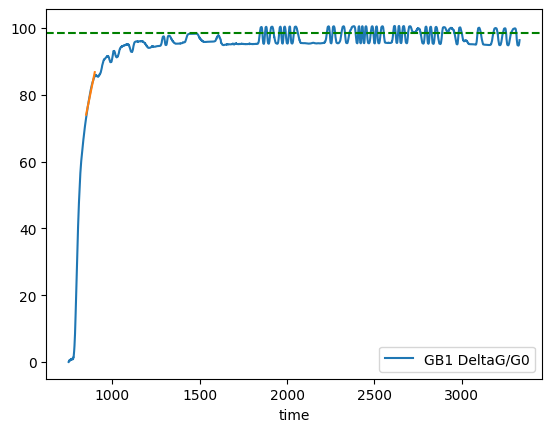

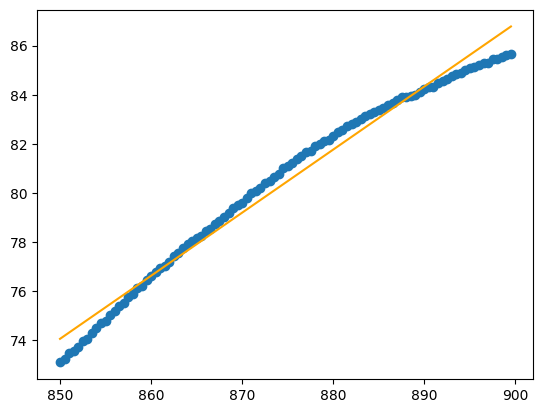

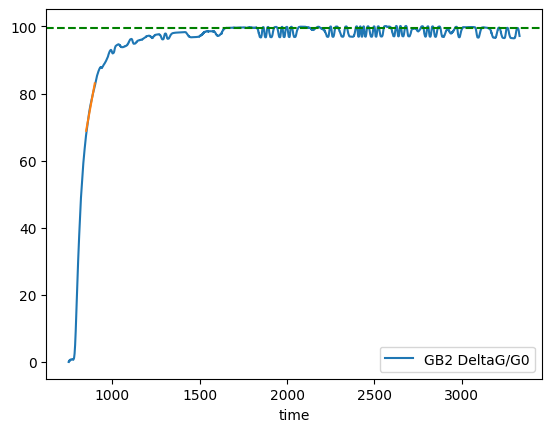

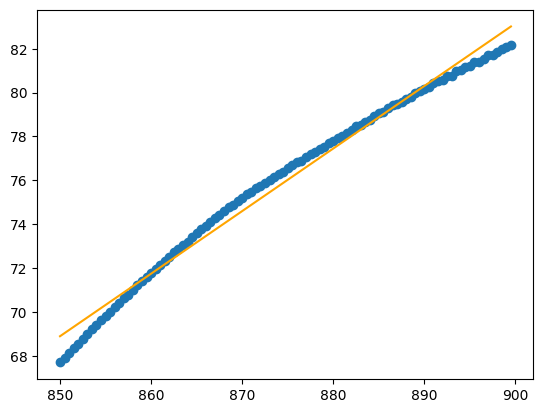

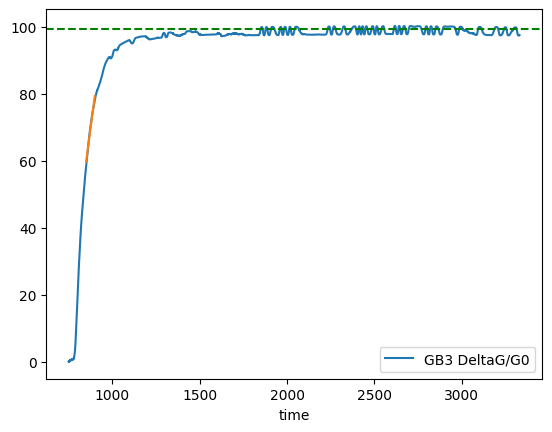

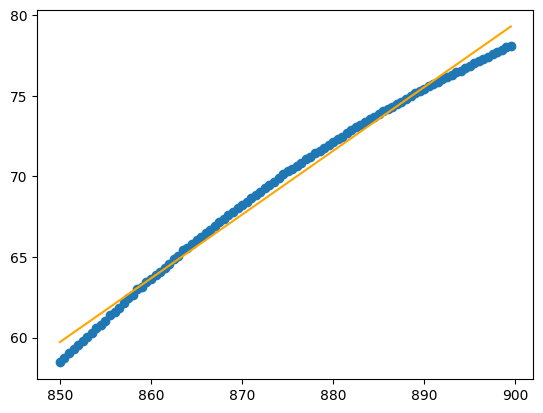

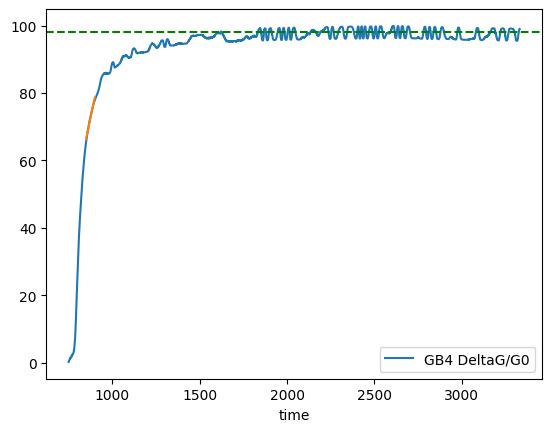

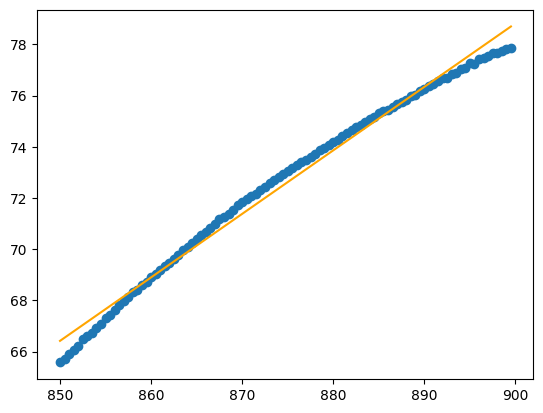

In [73]:
test.viz()

In [74]:
print(test.compute_initial_slope(20,600,0,0.1)[0])
print(test.compute_saturation())
print(test.compute_area())

[1.9361849675693334, 1.5482583343604446, 1.2051431400306394, 1.4838288917660671]
[98.56822400886834, 99.62978386578861, 99.40344396050958, 98.17446517362984]
[241723.8886419699, 244152.272025501, 243007.23352050892, 239705.57772069253]


In [75]:
print(test.vector_representation())

[[0.25689980300856885, 0.2853758276720528, 0.3954854526094412, 0.2480744210262696], [98.56822400886834, 99.62978386578861, 99.40344396050958, 98.17446517362984], [241723.8886419699, 244152.272025501, 243007.23352050892, 239705.57772069253]]


In [76]:
test2 = SensorResponse("Cu-COF-DC-8","NH3","air_humid",80)

In [77]:
print(test2.compute_initial_slope()[0])
print(test2.compute_saturation())
print(test2.compute_area())


[0.3253652566234526, 0.22760211465324867, 0.0, 0.0]
[65.30217906998811, 52.71640927978379, 100.0, 100.0]
[143523.8119352084, 115758.26203188971, 258000.0, 258000.0]


In [78]:
print(test2.vector_representation())

[[0.3253652566234526, 0.22760211465324867, 0.0, 0.0], [65.30217906998811, 52.71640927978379, 100.0, 100.0], [143523.8119352084, 115758.26203188971, 258000.0, 258000.0]]


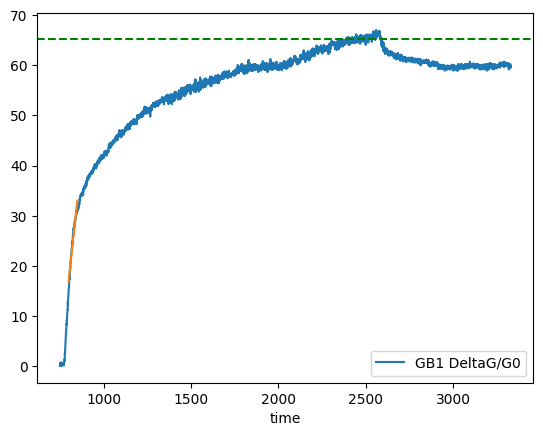

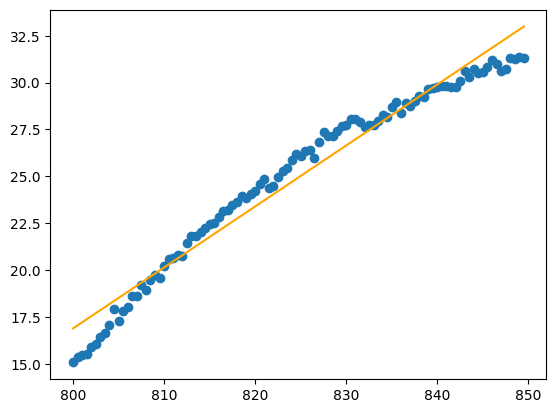

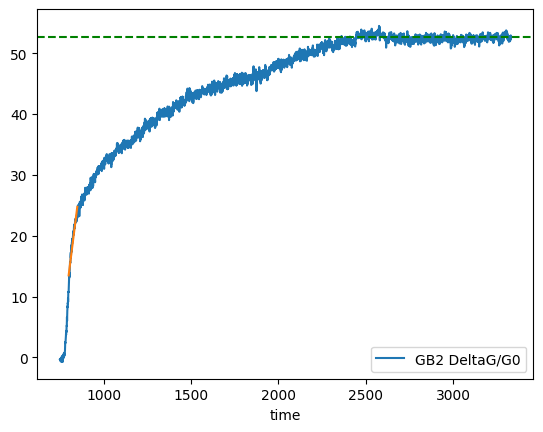

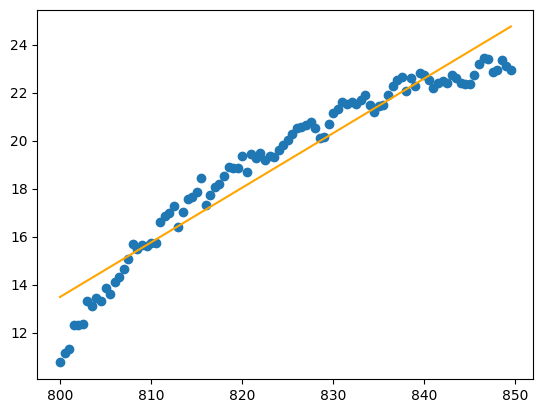

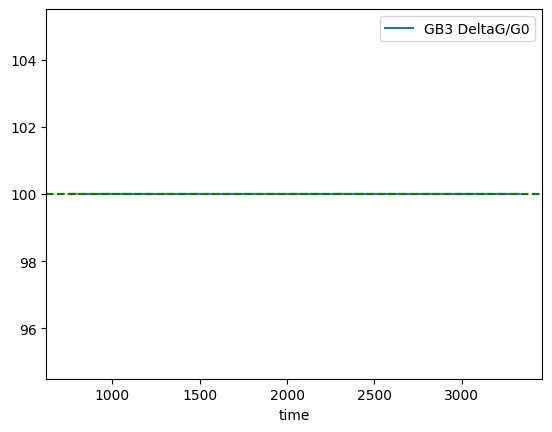

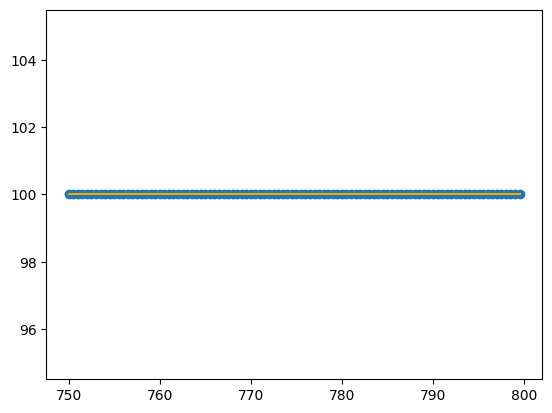

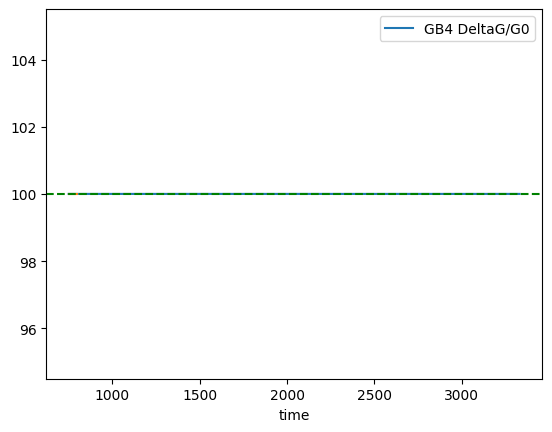

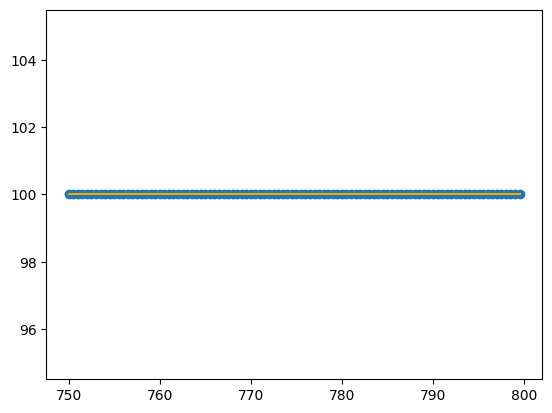

In [79]:
test2.viz()

In [80]:
test3 = SensorResponse("Co-COF-DC-8","CO","air_dry",80)

[[0.005766742995507678, 0.0, 0.0, 0.0], [3.3473010358528787, 100.0, 100.0, 100.0], [3582.1259367241273, 258000.0, 258000.0, 258000.0]]


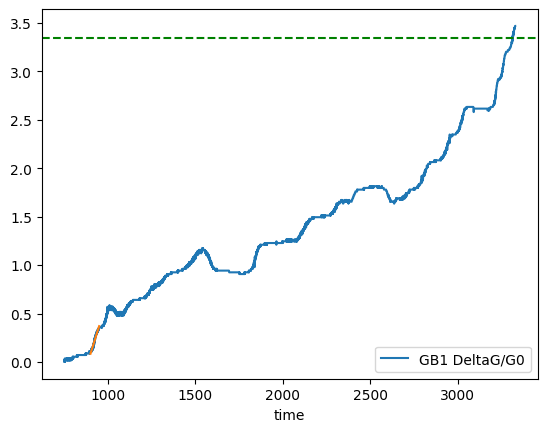

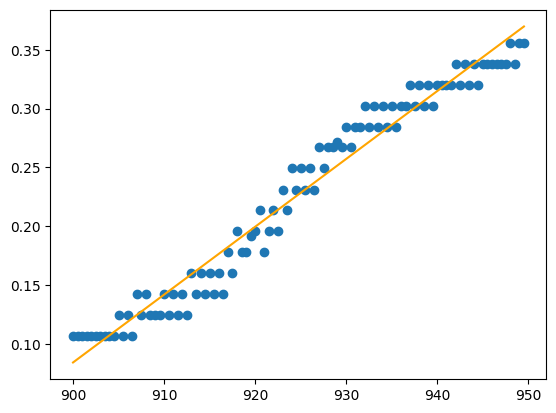

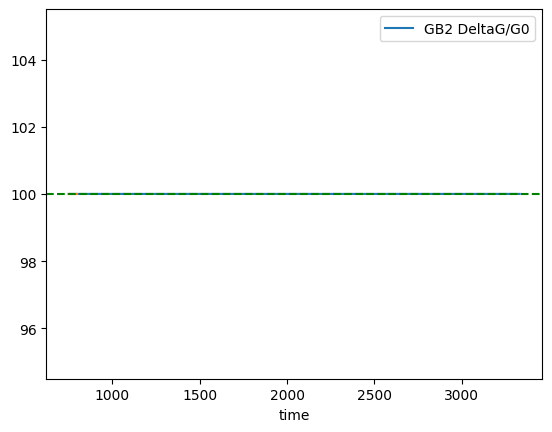

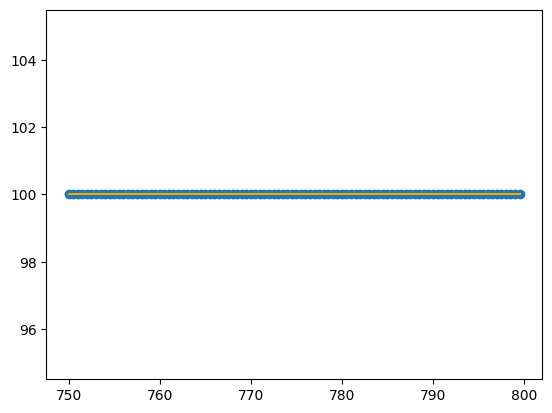

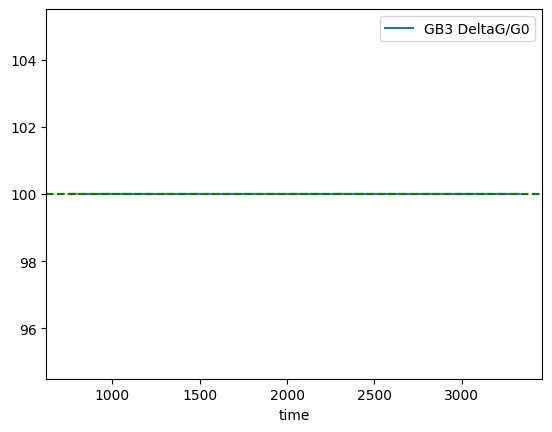

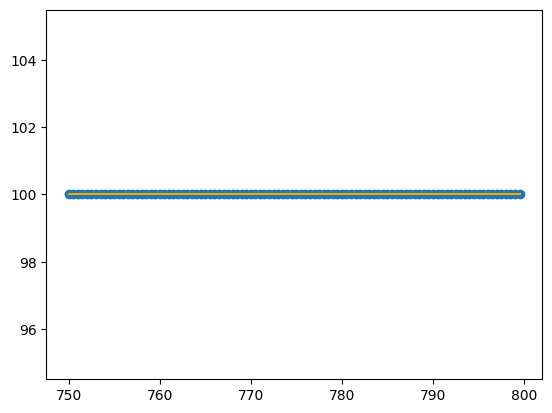

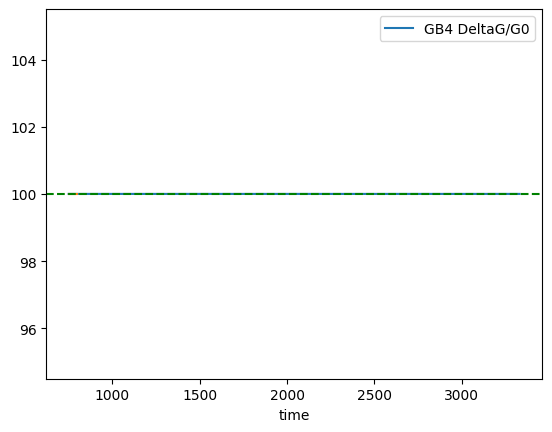

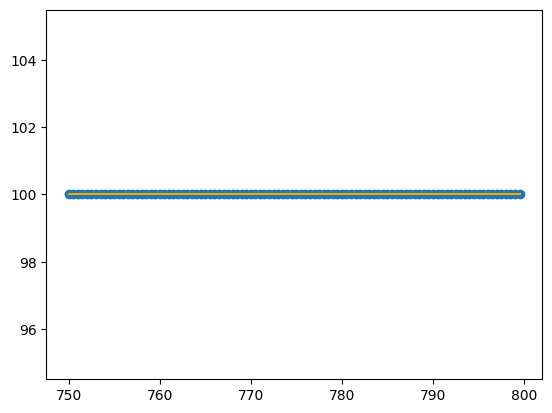

In [81]:
print(test3.vector_representation())
test3.viz()

In [82]:
test4 = SensorResponse("Co-COF-DC-8","NO","air_dry",80)

[[0.4220150141654046, 0.5116463163045474, 0.4118091337367221, 0.0], [-183.20928518122406, -255.0613768923525, -178.97288218914343, 100.0], [-403546.2003406406, -549183.0763421704, -389965.97295681835, 258000.0]]


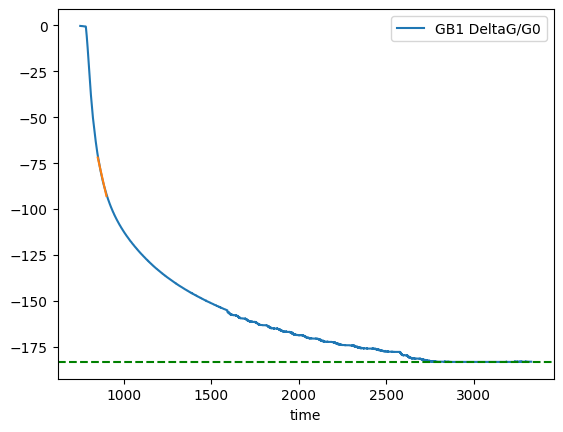

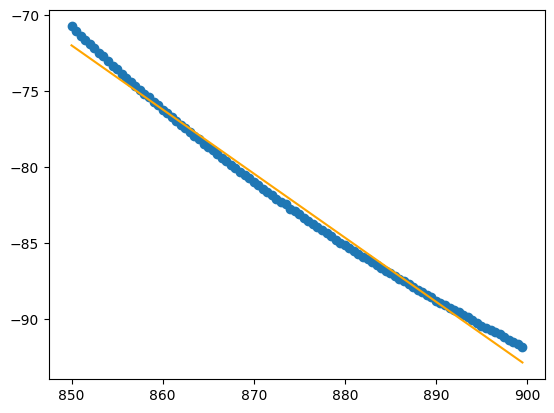

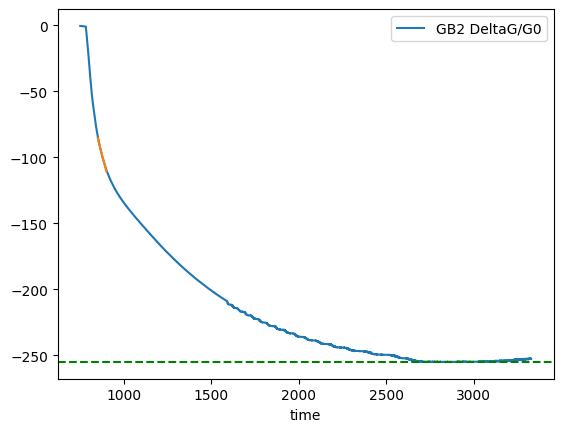

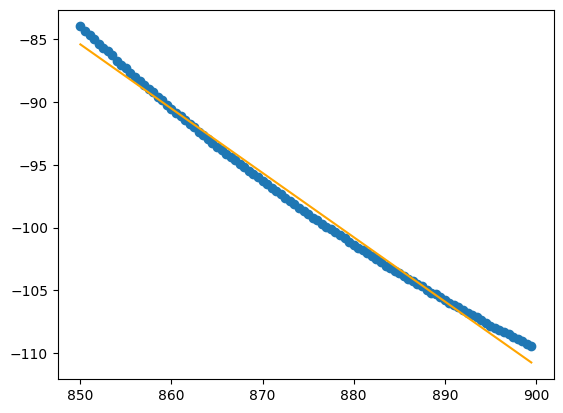

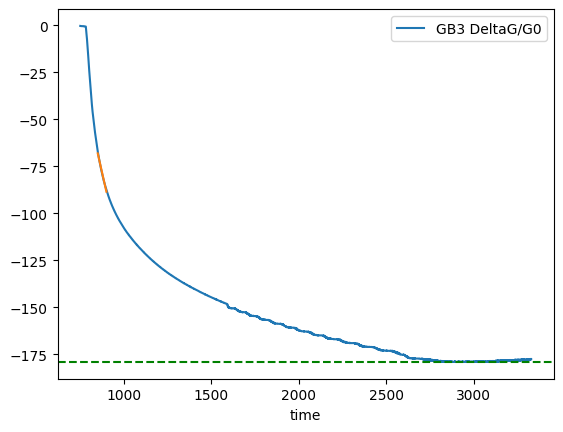

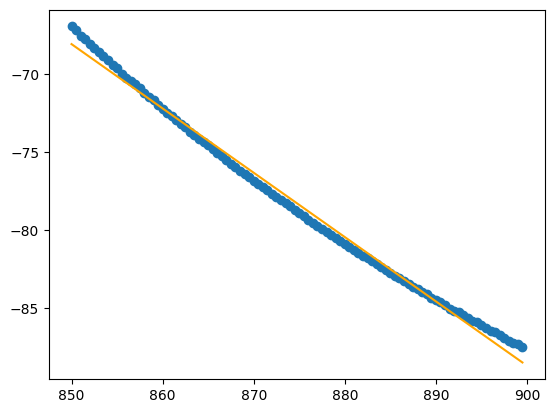

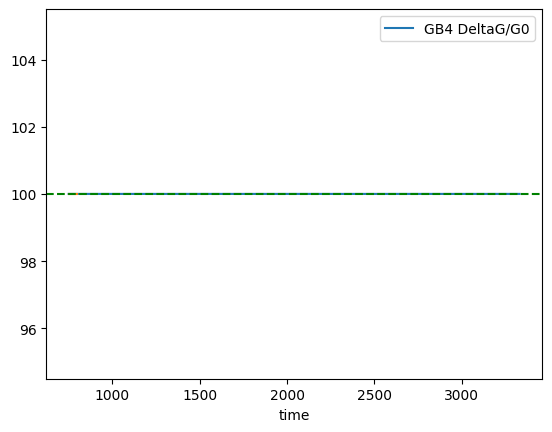

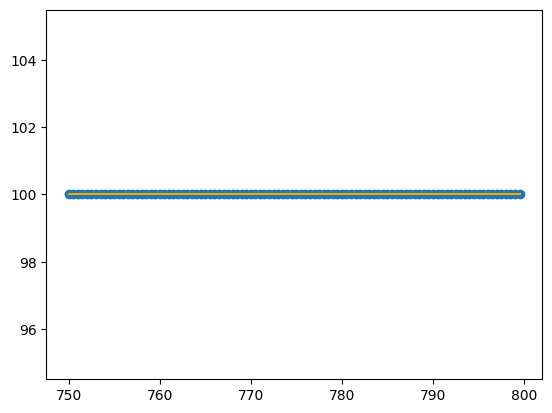

In [83]:
print(test4.vector_representation())
test4.viz()